# Model Performance

In [1]:
# load libraries
from dotenv import load_dotenv 
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
from numerapi import NumerAPI
import os

# set env vars
load_dotenv()
PUBLIC_ID = os.getenv('PUBLIC_ID')
SECRET_KEY = os.getenv('SECRET_KEY')

# set plot params
plt.rcParams["figure.figsize"] = (14, 5)
plt.style.use("bmh")

In [2]:
# instantiate
TODAY = dt.datetime.now()
AFTER_DATE = "2022-04-01"
AFTER_ERA = 310

nmr = yf.download('NMR-USD', start=AFTER_DATE, end=TODAY, progress=False)
napi = NumerAPI(public_id=PUBLIC_ID, secret_key=SECRET_KEY)

In [3]:
# get model ranking
def get_model_rankings(model_list):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.daily_model_performances(m))
        df['modelName'] = m
        df_list.append( df)
    df_all = pd.concat(df_list)
    return df_all

# get model round performance
def get_model_performance(model_list):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.daily_submissions_performances(m))
        df['modelName'] = m
        df_list.append( df)
    df_all = pd.concat(df_list)
    return df_all

# get model round performance aggregated
def get_model_performance_aggregated(data, score, by):
    df = pd.pivot_table(
        data=data.groupby(["modelName", by])[score].mean().reset_index(),
        values=score,
        index=[by],
        columns=["modelName"]
    )
    return df

# get model payout & staking history
def get_model_value(model_list, mode):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.round_model_performances(m))
        df["modelName"] = m
        df_list.append(df)
    df_all = pd.concat(df_list)
    df_all = df_all.loc[df_all["roundResolved"]==True]
    
    if mode == "payout":
        mode_value = "payout"
    elif mode == "staking":
        mode_value = "selectedStakeValue"
    else:
        print("Select either 'payout' or 'staking' as mode.")

    output = pd.pivot_table(
        df_all, 
        values=mode_value, 
        index=['roundResolveTime'], 
        columns=['modelName']).fillna(0)
    output["totalValue"] = output.sum(axis=1)

    return output

In [4]:
# nmr price
nmr_price = nmr[['Open', 'High', 'Low', 'Close']].mean(axis=1)[-1]
nmr_price

12.869720935821533

In [5]:
# get model names
model_list = napi.get_models().keys()
model_list

dict_keys(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast', 'dh_skulls', 'dh_dojo', 'dh_gaia', 'dh_terra', 'dh_spira'])

---
# Model Ranks

In [6]:
# get model rankings
rank = get_model_rankings(model_list=model_list)
rank.head()

,corrRank,corrRep,date,fncRank,fncRep,fncV3Rank,fncV3Rep,mmcRank,mmcRep,tcRank,tcRep,modelName
0,3104,0.009113,2023-01-06 00:00:00+00:00,5386,0.004718,8579.0,-0.001407,NaN,NaN,6052.0,0.000841,dh_foxhound
1,3579,0.007621,2023-01-05 00:00:00+00:00,5643,0.003743,8750.0,-0.002627,NaN,NaN,6460.0,-0.000142,dh_foxhound
2,3380,0.010026,2023-01-04 00:00:00+00:00,5562,0.003933,8527.0,-0.002193,NaN,NaN,6645.0,-0.000869,dh_foxhound
3,3310,0.010784,2023-01-03 00:00:00+00:00,5396,0.004514,8243.0,-0.001598,NaN,NaN,6737.0,-0.001110,dh_foxhound
4,3570,0.009760,2022-12-31 00:00:00+00:00,5629,0.003966,8629.0,-0.002363,NaN,NaN,6641.0,-0.000603,dh_foxhound


In [7]:
# check model name list
rank["modelName"].unique()

array(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast',
       'dh_skulls', 'dh_dojo', 'dh_gaia', 'dh_terra', 'dh_spira'],
      dtype=object)

In [8]:
# model lists
lgbm_models = ['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast', 'dh_skulls']
dnn_models = ['dh_dojo', 'dh_gaia', 'dh_terra', 'dh_spira']

In [9]:
# cols
tc_rank_cols = [col for col in rank.columns if col.endswith("Rank") and col.startswith("tc")]
tc_rep_cols = [col for col in rank.columns if col.endswith("Rep") and col.startswith("tc")]
nontc_rank_cols = [col for col in rank.columns if col.endswith("Rank") and not col.startswith("tc")]
nontc_rep_cols = [col for col in rank.columns if col.endswith("Rep") and not col.startswith("tc")]

tc_rank_cols, tc_rep_cols, nontc_rank_cols, nontc_rep_cols

(['tcRank'],
 ['tcRep'],
 ['corrRank', 'fncRank', 'fncV3Rank', 'mmcRank'],
 ['corrRep', 'fncRep', 'fncV3Rep', 'mmcRep'])

---
# Correlation Ranking & Reputation

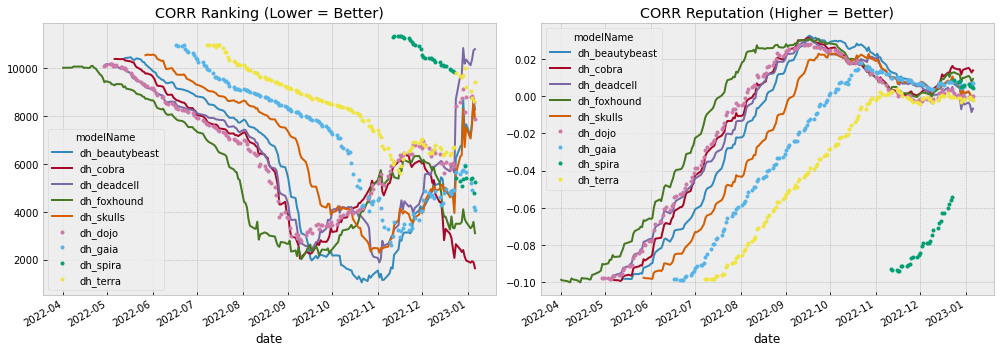

In [10]:
# plot  corr rank and rep
corrdf_lgbm = rank.loc[(rank["date"]>=AFTER_DATE) & (rank["modelName"].isin(lgbm_models))]
corrdf_dnn = rank.loc[(rank["date"]>=AFTER_DATE) & (rank["modelName"].isin(dnn_models))]

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False)

pd.pivot_table(
    data=corrdf_lgbm[["modelName", "date", "corrRank"]],
    values="corrRank",
    index="date",
    columns="modelName"
).plot(ax=axes[0], style='-')
pd.pivot_table(
    data=corrdf_dnn[["modelName", "date", "corrRank"]],
    values="corrRank",
    index="date",
    columns="modelName"
).plot(ax=axes[0], style='.')
axes[0].set_title("CORR Ranking (Lower = Better)")

pd.pivot_table(
    data=corrdf_lgbm[["modelName", "date", "corrRep"]],
    values="corrRep",
    index="date",
    columns="modelName"
).plot(ax=axes[1], style='-')
pd.pivot_table(
    data=corrdf_dnn[["modelName", "date", "corrRep"]],
    values="corrRep",
    index="date",
    columns="modelName"
).plot(ax=axes[1], style='.')
axes[1].set_title("CORR Reputation (Higher = Better)")

plt.tight_layout()
plt.savefig('plots/CorrRankPlots.png', facecolor='w')
plt.show()

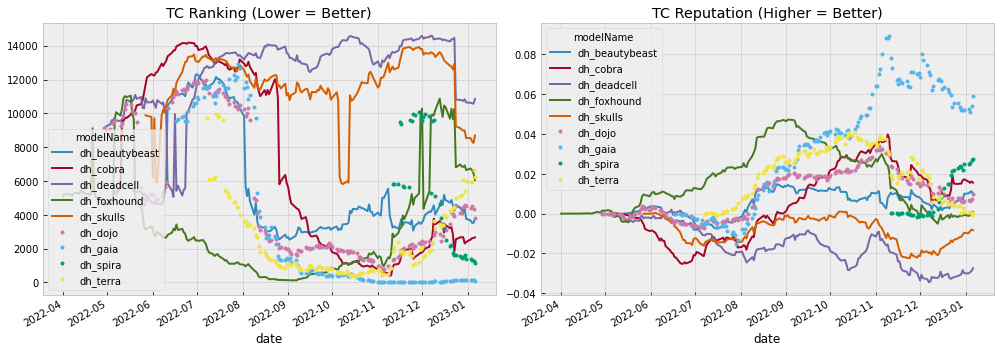

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False)
pd.pivot_table(
    data=corrdf_lgbm[["modelName", "date", "tcRank"]],
    values="tcRank",
    index="date",
    columns="modelName"
).plot(ax=axes[0], style='-')
pd.pivot_table(
    data=corrdf_dnn[["modelName", "date", "tcRank"]],
    values="tcRank",
    index="date",
    columns="modelName"
).plot(ax=axes[0], style='.')
axes[0].set_title("TC Ranking (Lower = Better)")

pd.pivot_table(
    data=corrdf_lgbm[["modelName", "date", "tcRep"]],
    values="tcRep",
    index="date",
    columns="modelName"
).plot(ax=axes[1], style='-')
pd.pivot_table(
    data=corrdf_dnn[["modelName", "date", "tcRep"]],
    values="tcRep",
    index="date",
    columns="modelName"
).plot(ax=axes[1], style='.')
axes[1].set_title("TC Reputation (Higher = Better)")

plt.tight_layout()
plt.savefig('plots/TCRankPlots.png', facecolor='w')
plt.show()

---
# Model Performance by Round

In [12]:
# get round performance
perf_lgbm = get_model_performance(model_list=lgbm_models)
perf_dnn = get_model_performance(model_list=dnn_models)
perf_all = get_model_performance(model_list=model_list)

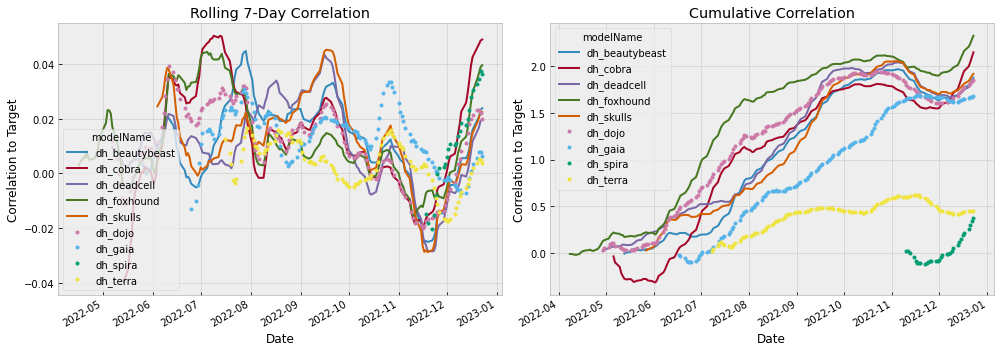

In [13]:
# get mean corr by round
lgbm_avg_corr_by_date = get_model_performance_aggregated(data=perf_lgbm, score="correlation", by="date")
dnn_avg_corr_by_date = get_model_performance_aggregated(data=perf_dnn, score="correlation", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
lgbm_avg_corr_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0], style='-')
dnn_avg_corr_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0], style='.')
lgbm_avg_corr_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1], style='-')
dnn_avg_corr_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1], style='.')
axes[0].set_title("Rolling 7-Day Correlation")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Correlation to Target")
axes[1].set_title("Cumulative Correlation")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Correlation to Target")
plt.tight_layout()
plt.savefig('plots/ModelCorrPlots.png', facecolor='w')
plt.show()

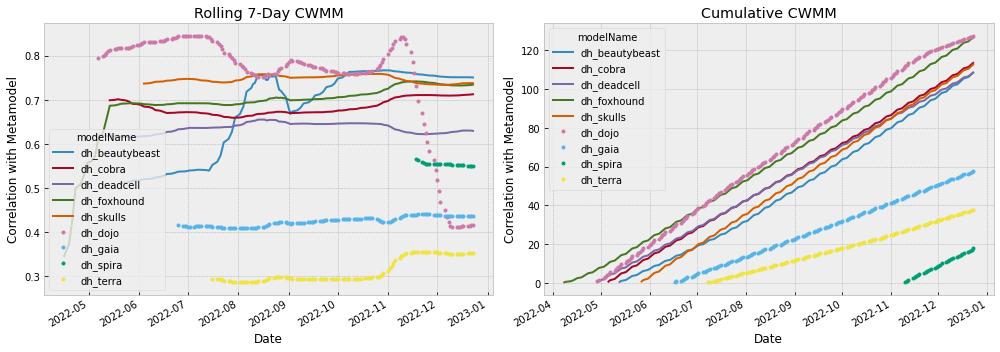

In [14]:
# get mean cwmm by round
lgbm_avg_cwmm_by_date = get_model_performance_aggregated(data=perf_lgbm, score="correlationWithMetamodel", by="date")
dnn_avg_cwmm_by_date = get_model_performance_aggregated(data=perf_dnn, score="correlationWithMetamodel", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
lgbm_avg_cwmm_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0], style='-')
dnn_avg_cwmm_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0], style='.')
lgbm_avg_cwmm_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1], style='-')
dnn_avg_cwmm_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1], style='.')
axes[0].set_title("Rolling 7-Day CWMM")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Correlation with Metamodel")
axes[1].set_title("Cumulative CWMM")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Correlation with Metamodel")
plt.tight_layout()
plt.savefig('plots/ModelCWMMPlots.png', facecolor='w')
plt.show()

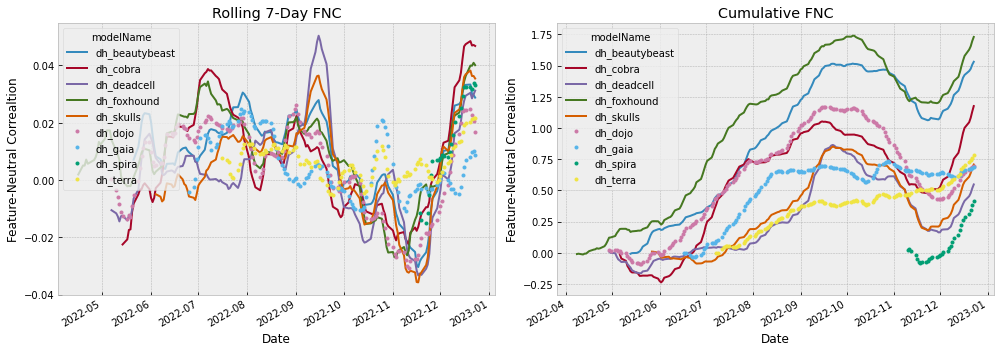

In [15]:
# get mean fnc by round
lgbm_avg_fnc_by_date = get_model_performance_aggregated(data=perf_lgbm, score="fnc", by="date")
dnn_avg_fnc_by_date = get_model_performance_aggregated(data=perf_dnn, score="fnc", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
lgbm_avg_fnc_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0], style='-')
dnn_avg_fnc_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0], style='.')
lgbm_avg_fnc_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1], style='-')
dnn_avg_fnc_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1], style='.')
axes[0].set_title("Rolling 7-Day FNC")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Feature-Neutral Correaltion")
axes[1].set_title("Cumulative FNC")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Feature-Neutral Correaltion")
plt.tight_layout()
plt.savefig('plots/ModelFNCPlots.png', facecolor='w')
plt.show()

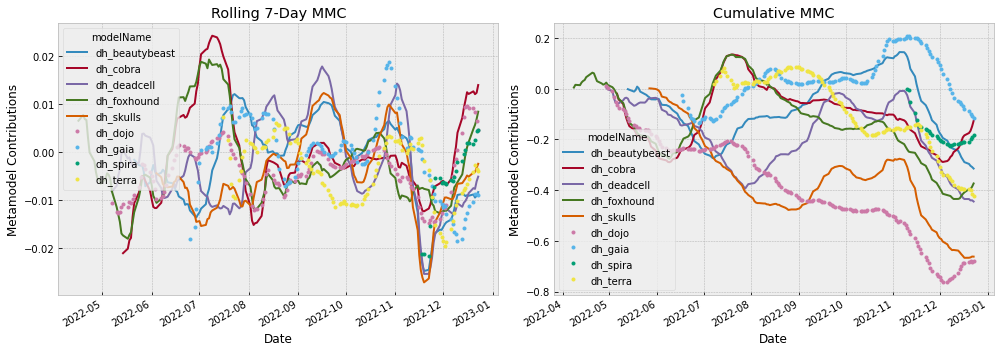

In [16]:
# get mean mmc by round
lgbm_avg_mmc_by_date = get_model_performance_aggregated(data=perf_lgbm, score="mmc", by="date")
dnn_avg_mmc_by_date = get_model_performance_aggregated(data=perf_dnn, score="mmc", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
lgbm_avg_mmc_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0], style='-')
dnn_avg_mmc_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0], style='.')
lgbm_avg_mmc_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1], style='-')
dnn_avg_mmc_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1], style='.')
axes[0].set_title("Rolling 7-Day MMC")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Metamodel Contributions")
axes[1].set_title("Cumulative MMC")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Metamodel Contributions")
plt.tight_layout()
plt.savefig('plots/ModelMMCPlots.png', facecolor='w')
plt.show()

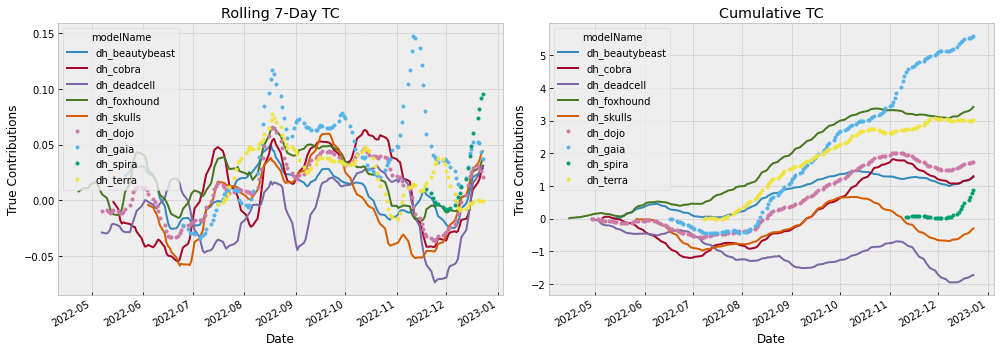

In [17]:
# get mean mmc by round
lgbm_avg_tc_by_date = get_model_performance_aggregated(data=perf_lgbm,score="tc", by="date")
dnn_avg_tc_by_date = get_model_performance_aggregated(data=perf_dnn,score="tc", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
lgbm_avg_tc_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0], style='-')
dnn_avg_tc_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0], style='.')
lgbm_avg_tc_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1], style='-')
dnn_avg_tc_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1], style='.')
axes[0].set_title("Rolling 7-Day TC")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("True Contributions")
axes[1].set_title("Cumulative TC")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("True Contributions")
plt.tight_layout()
plt.savefig('plots/ModelTCPlots.png', facecolor='w')
plt.show()

---
# Model Payouts & Staking

In [18]:
# get payout
payout_lgbm = get_model_value(lgbm_models, "payout")
payout_dnn = get_model_value(dnn_models, "payout")
payout_all = get_model_value(model_list, "payout")

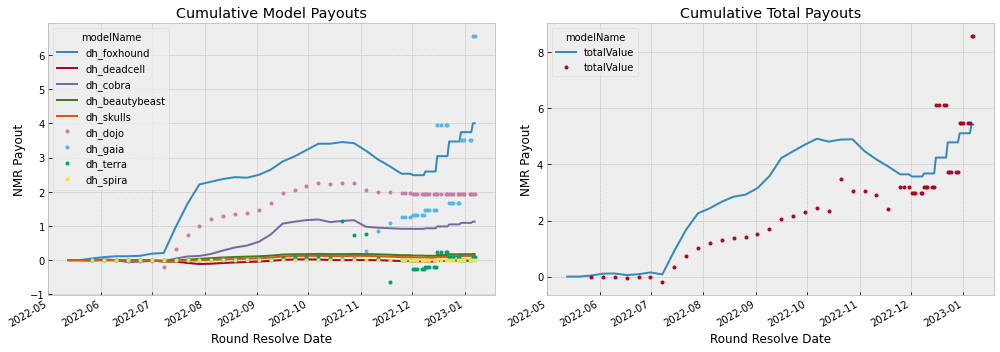

In [19]:
# plot payouts
try:
    fig, axes = plt.subplots(nrows=1, ncols=2)
    payout_lgbm.loc[AFTER_DATE:][lgbm_models].cumsum().plot(ax=axes[0], style='-')
    payout_dnn.loc[AFTER_DATE:][dnn_models].cumsum().plot(ax=axes[0], style='.')
    payout_lgbm.loc[AFTER_DATE:][["totalValue"]].cumsum().plot(ax=axes[1], style='-')
    payout_dnn.loc[AFTER_DATE:][["totalValue"]].cumsum().plot(ax=axes[1], style='.')
    axes[0].set_title("Cumulative Model Payouts")
    axes[0].set_xlabel("Round Resolve Date")
    axes[0].set_ylabel("NMR Payout")
    axes[1].set_title("Cumulative Total Payouts")
    axes[1].set_xlabel("Round Resolve Date")
    axes[1].set_ylabel("NMR Payout")
    plt.tight_layout()
    plt.savefig('plots/PayoutPlots.png', facecolor='w')
    plt.show()
except:
    pass

In [20]:
# get payout
staking_lgbm = get_model_value(lgbm_models, "staking")
staking_dnn = get_model_value(dnn_models, "staking")
staking_all = get_model_value(model_list, "staking")

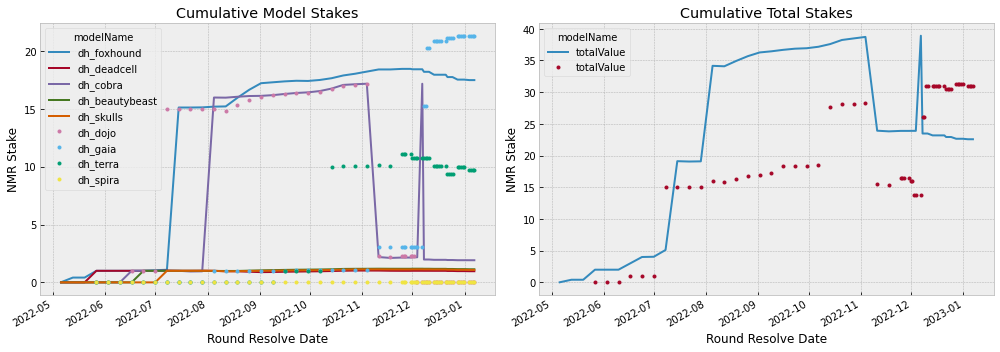

In [21]:
# plot payouts
try:
    fig, axes = plt.subplots(nrows=1, ncols=2)
    staking_lgbm.loc[AFTER_DATE:][lgbm_models].plot(ax=axes[0], style='-')
    staking_dnn.loc[AFTER_DATE:][dnn_models].plot(ax=axes[0], style='.')
    staking_lgbm.loc[AFTER_DATE:][["totalValue"]].plot(ax=axes[1], style='-')
    staking_dnn.loc[AFTER_DATE:][["totalValue"]].plot(ax=axes[1], style='.')
    axes[0].set_title("Cumulative Model Stakes")
    axes[0].set_xlabel("Round Resolve Date")
    axes[0].set_ylabel("NMR Stake")
    axes[1].set_title("Cumulative Total Stakes")
    axes[1].set_xlabel("Round Resolve Date")
    axes[1].set_ylabel("NMR Stake")
    plt.tight_layout()
    plt.savefig('plots/ModelStakingPlots.png', facecolor='w')
    plt.show()
except:
    pass

---
# Total Return

In [22]:
# daily staking 
round_return = pd.concat([payout_all["totalValue"], staking_all["totalValue"]], axis=1)[AFTER_DATE:].fillna(0)
round_return.columns = ["payout", "staking"]
round_return["return"] = round_return["payout"] / round_return["staking"]

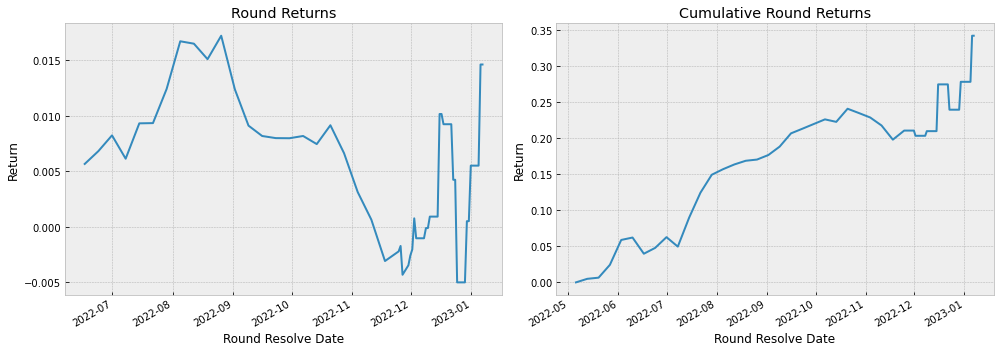

In [23]:
# plot round return
fig, axes = plt.subplots(nrows=1, ncols=2)
round_return["return"].rolling(7).mean().plot(ax=axes[0])
round_return["return"].cumsum().plot(ax=axes[1])
axes[0].set_title("Round Returns")
axes[0].set_xlabel("Round Resolve Date")
axes[0].set_ylabel("Return")
axes[1].set_title("Cumulative Round Returns")
axes[1].set_xlabel("Round Resolve Date")
axes[1].set_ylabel("Return")
plt.tight_layout()
plt.savefig('plots/TotalReturnPlots.png', facecolor='w')
plt.show()

---
# Sharpe Performance

In [24]:
# sharpe calc
def get_sharpe(df, metric):
    def sharpe(x):
        return x.mean() / x.std()
    df_clean = df.query(f"roundNumber >= {AFTER_ERA}").copy()
    sharpe_df = pd.concat([
        df_clean.groupby(["modelName"])[metric].size(),
        df_clean.groupby(["modelName"])[metric].apply(lambda x: sharpe(x))], 
        axis=1)
    sharpe_df.columns = ["n", "sharpe"]
    sharpe_df = sharpe_df.loc[sharpe_df["n"]>=10].sort_values("sharpe")
    return sharpe_df

In [25]:
# rank by sharpe
corr_sharpe_df = get_sharpe(df=perf_all, metric='correlation')
tc_sharpe_df = get_sharpe(df=perf_all, metric='tc')

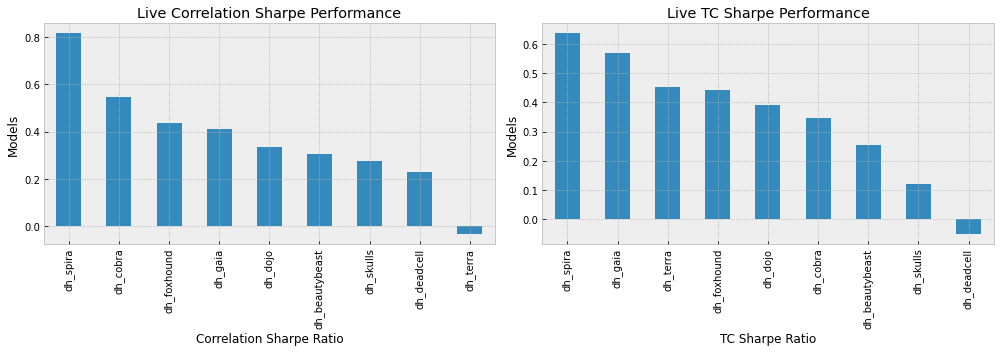

In [26]:
# plot both
fig, axes = plt.subplots(nrows=1, ncols=2)
corr_sharpe_df["sharpe"].sort_values(ascending=False).plot.bar(ax=axes[0])
tc_sharpe_df["sharpe"].sort_values(ascending=False).plot.bar(ax=axes[1])
axes[0].set_title("Live Correlation Sharpe Performance")
axes[0].set_xlabel("Correlation Sharpe Ratio")
axes[0].set_ylabel("Models")
axes[1].set_title("Live TC Sharpe Performance")
axes[1].set_xlabel("TC Sharpe Ratio")
axes[1].set_ylabel("Models")
plt.tight_layout()
plt.savefig('plots/SharpeRatioPlots.png', facecolor='w')
plt.show();

In [27]:
# sharpe calc (ts)
def get_sharpe_ts(df, metric):
    def sharpe(x):
        return x.mean() / x.std()
    df_clean = df.query(f"roundNumber >= {AFTER_ERA}").copy()
    sharpe_df = pd.concat([
        df_clean.groupby(["roundNumber", "modelName"])[metric].size(),
        df_clean.groupby(["roundNumber", "modelName"])[metric].apply(lambda x: sharpe(x))], 
        axis=1)
    sharpe_df.columns = ["n", "sharpe"]
    sharpe_df = (
        sharpe_df
        .loc[sharpe_df["n"]>=10]
        .reset_index()
        .sort_values(["modelName", "roundNumber"])
        .drop("n", axis=1)
        .pivot(index='roundNumber', columns='modelName', values='sharpe'))
    return sharpe_df

In [28]:
# rank by sharpe ts
corr_sharpets_df = get_sharpe_ts(df=perf_all, metric='correlation')
tc_sharpets_df = get_sharpe_ts(df=perf_all, metric='tc')

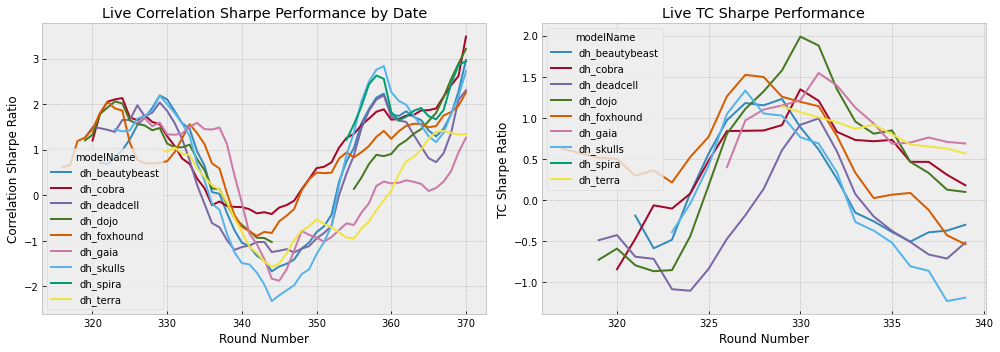

In [29]:
# plot both
fig, axes = plt.subplots(nrows=1, ncols=2)
corr_sharpets_df.rolling(7).mean().plot(ax=axes[0])
tc_sharpets_df.rolling(7).mean().plot(ax=axes[1])
axes[0].set_title("Live Correlation Sharpe Performance by Date")
axes[0].set_xlabel("Round Number")
axes[0].set_ylabel("Correlation Sharpe Ratio")
axes[1].set_title("Live TC Sharpe Performance")
axes[1].set_xlabel("Round Number")
axes[1].set_ylabel("TC Sharpe Ratio")
plt.tight_layout()
plt.savefig('plots/SharpeRatioTSPlots.png', facecolor='w')
plt.show();